<a href="https://colab.research.google.com/github/William-Thomas-Andrews/LLM_Text_Detection/blob/main/LLM_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import re
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import keras
import math
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
import tensorflow as tf
from sklearn.metrics import classification_report,confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.layers import Bidirectional
import string

In [ ]:
%%time
# Read the parquet file into a DataFrame
df = pd.read_parquet("/content/drive/MyDrive/AI_Detector_Project/data.parquet")

item0 = df.shape[0]  # Store the initial number of items in the DataFrame
df = df.drop_duplicates()  # Remove duplicate rows from the DataFrame
item1 = df.shape[0]  # Store the number of items in the DataFrame after removing duplicates
print(f"There are {item0-item1} duplicates found in the dataset")  # Print the number of duplicates removed

df = df.rename(columns={'text': 'title', 'source': 'label'})

df = df[['label', 'title']]  # Select only the 'label' and 'title' columns
df = df[~df['title'].isnull()]  # Remove rows where 'title' is null
df = df[~df['label'].isnull()]  # Remove rows where 'label' is null


print(df.shape)  # Print the shape of the DataFrame after data preprocessing
df.sample(5).T  # Display a random sample of 5 rows from the DataFrame

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
df.isnull().sum()

label    0
title    0
dtype: int64

In [ ]:
df.columns

Index(['label', 'title'], dtype='object')

In [ ]:
df.shape

(788922, 2)

In [ ]:
df_testing = df.copy()

In [ ]:
df_testing = df_testing.rename(columns={"label": "Author", "title": "Content"})

In [ ]:
df_testing

,Author,Content
0,Bloom-7B,"Federal law supersedes state law, and cannabis..."
1,Bloom-7B,Miles feels restless after working all day. He...
2,Bloom-7B,So first of I am danish. That means that I fol...
3,Bloom-7B,In this paper we present a novel rule-based ap...
4,Bloom-7B,"Most social progressives, love democracy, and ..."
...,...,...
788917,YI-34B,"\nIn the vast expanse of time, where the echoe..."
788918,YI-34B,"\nThe phenomenon of brain drain, particularly ..."
788919,YI-34B,\nThe Influence of Climate Change on Marine Ec...
788920,YI-34B,\nTitle: The Case for Limiting Car Usage: Navi...


In [ ]:
df_testing['Content'] = df_testing['Content'].apply(lambda x: x.replace('\n', ' '))

In [ ]:
df_testing['Content']

0         Federal law supersedes state law, and cannabis...
1         Miles feels restless after working all day. He...
2         So first of I am danish. That means that I fol...
3         In this paper we present a novel rule-based ap...
4         Most social progressives, love democracy, and ...
                                ...                        
788917     In the vast expanse of time, where the echoes...
788918     The phenomenon of brain drain, particularly i...
788919     The Influence of Climate Change on Marine Eco...
788920     Title: The Case for Limiting Car Usage: Navig...
788921     In the vast expanse of a globalized society, ...
Name: Content, Length: 788922, dtype: object

In [ ]:
df_testing['Author'].where(df_testing['Author'] != 'Human', 'LLM')

0         Bloom-7B
1         Bloom-7B
2         Bloom-7B
3         Bloom-7B
4         Bloom-7B
            ...   
788917      YI-34B
788918      YI-34B
788919      YI-34B
788920      YI-34B
788921      YI-34B
Name: Author, Length: 788922, dtype: object

In [ ]:
df_testing

,Author,Content
0,Bloom-7B,"Federal law supersedes state law, and cannabis..."
1,Bloom-7B,Miles feels restless after working all day. He...
2,Bloom-7B,So first of I am danish. That means that I fol...
3,Bloom-7B,In this paper we present a novel rule-based ap...
4,Bloom-7B,"Most social progressives, love democracy, and ..."
...,...,...
788917,YI-34B,"In the vast expanse of time, where the echoes..."
788918,YI-34B,"The phenomenon of brain drain, particularly i..."
788919,YI-34B,The Influence of Climate Change on Marine Eco...
788920,YI-34B,Title: The Case for Limiting Car Usage: Navig...


In [ ]:
df_testing.loc[df_testing['Author'] != 'Human', 'Author'] = 'LLM'

In [ ]:
df_testing['Author'].value_counts()

Author
LLM      441230
Human    347692
Name: count, dtype: int64

## The no-information model guess would be:

In [ ]:
no_information_LLM = df_testing['Author'].value_counts()[0] / (df_testing['Author'].value_counts()[1] + df_testing['Author'].value_counts()[0])
print(f'The guess of the likelihood of the text being from a LLM given no information is: {no_information_LLM:.3f}')

The guess of the likelihood of the text being from a LLM given no information is: 0.559


In [ ]:
no_information_Human = df_testing['Author'].value_counts()[1] / (df_testing['Author'].value_counts()[1] + df_testing['Author'].value_counts()[0])
print(f'The guess of the likelihood of the text being from a Human given no information is: {no_information_Human:.3f}')

The guess of the likelihood of the text being from a Human given no information is: 0.441


In [ ]:
df_testing['Author'].value_counts()

Author
LLM      441230
Human    347692
Name: count, dtype: int64

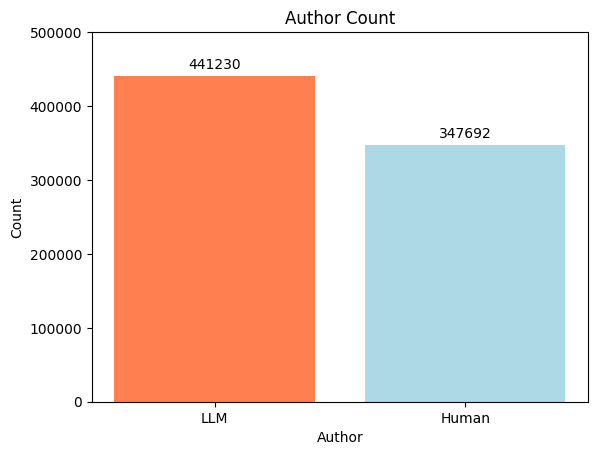

In [ ]:
import matplotlib.pyplot as plt

authors = ['LLM', 'Human']
counts = [441230, 347692]

fig, ax = plt.subplots()

bars = ax.bar(authors, counts, color=['coral', 'lightblue'])

ax.set_ylim(0, 500000)
ax.set_title('Author Count')
ax.set_xlabel('Author')
ax.set_ylabel('Count')

for bar in bars:
    height = bar.get_height()
    ax.annotate('{}'.format(height),
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

plt.show()

## The data set does not seem unbalanced. It is not a perfect 50/50 split, but the proportions are not bad.

In [ ]:
lm = WordNetLemmatizer()

In [ ]:
# \/ 21m

In [ ]:
punct = set(string.punctuation)
# stopwords = set(stopwords.words('english'))
stopwords_set = set(stopwords.words('english'))
corpus = []

for i in range(len(df_testing)):
  text = df_testing['Content'].iloc[i].lower()
  text = text.translate(str.maketrans('', '', string.punctuation)).split()
  text = [lm.lemmatize(word) for word in text if word not in stopwords_set]
  text = ' '.join(text)
  corpus.append(text)

In [ ]:
corpus[0]

'federal law supersedes state law cannabis medical recreational use still prohibited federal law reason give keeping illegal never hold water though weve consolidated argument side legality debate one comprehensive list prohibitionist argue marijuana drug banned buy legally town there way stop people using illegally mean would criminal wider range dangerous substance disposal ever thats almost every country ban alcohol available hard keep track opponent different opinion dont believe prohibition solves problem instead think cause harm good creating unscrupulous black market drug user forced pay high price highquality product'

In [ ]:
len(corpus)

788922

In [ ]:
lm.lemmatize('abilities')

'ability'

In [ ]:
df_testing2 = df_testing.copy()

In [ ]:
df_testing2

,Author,Content
0,LLM,federal law supersedes state law cannabis medi...
1,LLM,mile feel restless working day decides go park...
2,LLM,first danish mean follow american politics muc...
3,LLM,paper present novel rulebased approach runtime...
4,LLM,social progressive love democracy relatively l...
...,...,...
788917,LLM,vast expanse time echo aeon mingle whisper for...
788918,LLM,phenomenon brain drain particularly stem field...
788919,LLM,influence climate change marine ecosystem clim...
788920,LLM,title case limiting car usage navigating towar...


In [ ]:
df_testing2['Content'] = corpus

In [ ]:
df_testing2['Content'][0]

'federal law supersedes state law cannabis medical recreational use still prohibited federal law reason give keeping illegal never hold water though weve consolidated argument side legality debate one comprehensive list prohibitionist argue marijuana drug banned buy legally town there way stop people using illegally mean would criminal wider range dangerous substance disposal ever thats almost every country ban alcohol available hard keep track opponent different opinion dont believe prohibition solves problem instead think cause harm good creating unscrupulous black market drug user forced pay high price highquality product'

## Saving progress in a checkpoint because the data preprocessing took so long.

In [ ]:
df_testing2.to_csv('df_testing2.csv', index=False)

## Resuming progress.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import re
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import keras
import math
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
import tensorflow as tf
from sklearn.metrics import classification_report,confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.layers import Bidirectional
import string
import spacy

In [ ]:
df_testing3 = pd.read_csv("/content/drive/MyDrive/df_testing2.csv")

In [ ]:
df_testing3['Author'].value_counts()

Author
LLM      441230
Human    347692
Name: count, dtype: int64

In [ ]:
df_testing3.isna().sum()

Author     0
Content    2
dtype: int64

In [ ]:
df_testing3[df_testing3['Content'].isna()]

,Author,Content
590782,LLM,NaN
731127,LLM,NaN


In [ ]:
df_testing4 = df_testing3.drop([590782, 731127])

In [ ]:
df_testing4.isna().sum()

Author     0
Content    0
dtype: int64

In [ ]:
df_testing4['Author'] = df_testing4['Author'].map({'Human': 0, 'LLM': 1})

In [ ]:
df_testing4['Author'].value_counts()

Author
1    441228
0    347692
Name: count, dtype: int64

In [ ]:
df_testing4

,Author,Content
0,1,federal law supersedes state law cannabis medi...
1,1,mile feel restless working day decides go park...
2,1,first danish mean follow american politics muc...
3,1,paper present novel rulebased approach runtime...
4,1,social progressive love democracy relatively l...
...,...,...
788917,1,vast expanse time echo aeon mingle whisper for...
788918,1,phenomenon brain drain particularly stem field...
788919,1,influence climate change marine ecosystem clim...
788920,1,title case limiting car usage navigating towar...


## Huge data set, let's just split into 1/2 of the size for now for simplicity.

In [ ]:
half_len = len(df_testing4) // 2

df_half = df_testing4.sample(n=half_len, random_state=42)

In [ ]:
len(df_half)

394460

In [ ]:
df_half['Author'].value_counts()

Author
1    220321
0    174139
Name: count, dtype: int64

## No information guess model. This is the percentage the model guesses the author is a LLM, based on no information.

In [ ]:
df_half['Author'].value_counts()[0] / (df_half['Author'].value_counts()[0] + df_half['Author'].value_counts()[1])

0.441461745170613

In [ ]:
max_word=5000 #the maximum number of words to keep, based on word frequency.
max_sequence_length = 1000

In [ ]:
tokenizer = Tokenizer(num_words=max_word, split=' ')
tokenizer.fit_on_texts(df_half['Content'].values)
X = tokenizer.texts_to_sequences(df_half['Content'].values)
X= pad_sequences(X, maxlen=max_sequence_length)

In [ ]:
y = df_half['Author']

In [ ]:
from sklearn.model_selection import train_test_split as tts
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.1, random_state=42)

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense
from keras.optimizers import Adam

In [ ]:
tf.keras.mixed_precision.set_global_policy('mixed_float16')

model1 = Sequential()
model1.add(Embedding(max_word, 1000, input_length=max_sequence_length))
model1.add(Bidirectional(LSTM(128, dropout=0.5, return_sequences=True)))
model1.add(Bidirectional(LSTM(64, dropout=0.5)))
model1.add(Dense(1, activation='sigmoid'))

learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

model1.compile(optimizer = optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [26]:
history = model1.fit(X_train, y_train, epochs=2, batch_size = 50, validation_data=(X_test, y_test))

Epoch 1/2
7101/7101 [==============================] - 1243s 173ms/step - loss: 0.3233 - accuracy: 0.8460 - val_loss: 0.2483 - val_accuracy: 0.8859
Epoch 2/2
7101/7101 [==============================] - 1066s 150ms/step - loss: 0.2215 - accuracy: 0.9004 - val_loss: 0.2299 - val_accuracy: 0.8956


## Long training time, saving the model as a pkl file so I don't have to retrain.

In [43]:
import pickle
filename = 'model1.pkl'

# Open a file in write-binary mode and use pickle to dump the model
with open(filename, 'wb') as file:
    pickle.dump(model1, file)

In [32]:
with open(filename, 'rb') as file:
    loaded_model = pickle.load(file)

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')

## Defining a function to test some manual inputs.

In [129]:
def test_sample(content, max_sequence_length = max_sequence_length):
  # punct = set(string.punctuation)
  # stopwords = set(stopwords.words('english'))
  stopwords_set = set(stopwords.words('english'))
  lm = WordNetLemmatizer()

  text = content.lower()
  text = text.translate(str.maketrans('', '', string.punctuation)).split()
  text = [lm.lemmatize(word) for word in text if word not in stopwords_set]
  text = ' '.join(text)
  formatted_text = ' '.join(content.split())
  xi = tokenizer.texts_to_sequences([formatted_text])
  xi = pad_sequences(xi, maxlen=max_sequence_length)
  predicted_decimal = loaded_model.predict(xi)
  predicted_class = 'Human' if (predicted_decimal < 0.5) else 'LLM'
  probabilities = [(1 - predicted_decimal), (predicted_decimal)]
  final_answer = (f'The model predicts this text is written by a {predicted_class} and the probabilities of Human vs a LLM are {probabilities[0]} and {probabilities[1]}, respectively.')
  return final_answer

## I generated a some AI essays, pulled some internet articles, and also used two of my personal essays to test the model. I tested the theme of Golf statistics for human and LLM cases to confound for topic. I also used the Enron scandal as the second topic. For the third topic I used the history of scissors.

# Let's do some testing with some essays I manually inputted:

## A ChatGPT generated essay:

In [130]:
text = """
Golf, often revered as a sport of precision and patience, is deeply rooted in statistical analysis. From tracking player performance to understanding course difficulty, statistics play an integral role in shaping strategies and predicting outcomes. This essay delves into the various facets of golf statistics, highlighting their significance and applications in enhancing the game. Statistics in golf serve multiple purposes. They help players and coaches make informed decisions, enable analysts to evaluate performance, and allow fans to engage more deeply with the sport. By examining key metrics, one can gain insights into a player's strengths, weaknesses, and overall game plan. The scoring average is one of the most fundamental statistics in golf, representing the average number of strokes a player takes per round. It provides a general measure of a player's performance over time. A lower scoring average typically indicates a more consistent and successful player. Greens in regulation (GIR) is a critical statistic that measures how often a player reaches the green in the prescribed number of strokes (two strokes under par). For example, reaching a par-4 hole in two shots. High GIR percentages are indicative of strong iron play and accuracy, essential for scoring opportunities. Driving statistics include both distance and accuracy. Driving distance measures the average length of a player's drives, reflecting power. Driving accuracy, on the other hand, indicates the percentage of drives that land in the fairway, highlighting precision. Balancing these two aspects is crucial for effective play. Putting is often considered the most crucial aspect of golf, and several metrics help analyze it: putts per round, putts per green in regulation, and putts per round. The total number of putts a player takes in a round is fewer putts per round generally mean better performance. Putts per green in regulation (GIR) shows the average number of putts taken after reaching the green in regulation, offering insight into a player's ability to convert GIR into lower scores. Sand save percentage measures the percentage of times a player successfully gets up and down from a greenside bunker, resulting in par or better. It reflects a player's skill and composure in challenging situations. With advancements in technology, more sophisticated metrics have emerged, providing deeper insights. Strokes gained is a comprehensive metric that compares a player's performance to the field average. It breaks down various aspects such as strokes gained off the tee, approaching the green, around the green, and putting. This analysis helps identify specific areas where a player excels or needs improvement. The PGA Tour's ShotLink system uses lasers and GPS technology to track every shot by every player. This data provides a detailed breakdown of shot distances, locations, and outcomes, enabling precise performance analysis and strategy development. Golfers and their coaches use statistical analysis to tailor training programs and on-course strategies. For example, by identifying weaknesses in putting or bunker play, a player can focus practice sessions on those areas. During tournaments, players might adjust their approach based on statistical insights about the course and competition. Additionally, statisticians and analysts play a vital role in course design and setup. Understanding how different players navigate a course allows for adjustments that can make tournaments more challenging and engaging. As technology continues to evolve, the scope of golf statistics is expected to expand further. Wearable devices, augmented reality, and artificial intelligence are poised to revolutionize data collection and analysis, providing even more granular insights. This progress will not only enhance player performance but also enrich the viewing experience for fans, offering unprecedented levels of engagement and understanding. Statistics are the backbone of modern golf, offering a window into the intricacies of the game. From basic metrics like scoring averages to advanced analytics such as strokes gained, these numbers tell the story of a player's journey and strategy. As the sport continues to evolve, so too will the methods and tools used to analyze it, ensuring that golf remains a game of not just skill and precision, but also of insightful and strategic thinking.
"""

In [131]:
test_sample(text)

1/1 [==============================] - 0s 62ms/step


'The model predicts this text is written by a LLM and the probabilities of Human vs a LLM are [[0.]] and [[1.]], respectively.'

## Correct with 100% Confidence!

## An almost identical ChatGPT generated essay:

In [110]:
text = """
Golf, often described as a game of inches, is deeply rooted in precision, skill, and strategy. The sport, which captivates millions around the world, is as much about numbers and statistics as it is about the beauty of the swing or the serenity of the course. Understanding golf statistics provides valuable insights into a player's performance, the intricacies of the game, and the factors that separate the elite from the rest. These statistics are not just numbers; they tell the story of the game, offering a deeper appreciation for the nuances of golf. One of the most fundamental statistics in golf is the "score," which is the total number of strokes a player takes to complete a round. While this seems straightforward, it encompasses various elements of the game, including driving, approach shots, putting, and course management. A player's score relative to par is often used to gauge performance, with par being the expected number of strokes an expert golfer would take to complete the course. Scores below par indicate exceptional play, while those above par suggest areas for improvement. Driving statistics are crucial for understanding a player's performance off the tee. Metrics such as "Driving Distance" and "Driving Accuracy" provide insights into a player's power and precision. Driving Distance measures how far a player hits the ball from the tee, with the current average on the PGA Tour hovering around 295 yards. Longer drives can offer significant advantages, such as shorter approach shots to the green, but only if they are accurate. Driving Accuracy, on the other hand, measures the percentage of drives that land in the fairway. A balance between distance and accuracy is essential for setting up favorable positions for subsequent shots. Approach shots, or the shots taken to get the ball onto the green, are another critical aspect of golf. "Greens in Regulation" (GIR) is a key statistic that measures the percentage of holes in which a player reaches the green in the expected number of strokes. For example, reaching a par-4 green in two shots or a par-5 green in three shots would count towards this metric. High GIR percentages indicate strong approach play and often correlate with lower scores, as they suggest the player is consistently giving themselves opportunities for birdies and pars. Putting, often considered the most critical aspect of scoring, is measured through various statistics. "Putts per Round" provides a basic measure of putting performance, but more detailed metrics like "Strokes Gained: Putting" offer deeper insights. Strokes Gained: Putting quantifies a player's performance on the greens relative to the field, accounting for the difficulty of putts. This statistic helps identify the best putters, who can save strokes by sinking challenging putts and minimizing three-putts. Another essential set of statistics involves short game performance, which includes shots taken around the green. "Scrambling" measures a player's ability to save par after missing the green in regulation. High scrambling percentages indicate proficiency in chipping, pitching, and bunker play, reflecting a player's skill in recovering from challenging situations. Beyond individual performance metrics, course statistics also play a significant role in golf. Course difficulty, weather conditions, and even grass types can influence a player's performance. Understanding these factors helps in analyzing how well a player adapts to different challenges and conditions, offering a more comprehensive view of their abilities. Advanced analytics have revolutionized the way golf statistics are used and understood. Tools like ShotLink, used by the PGA Tour, collect vast amounts of data on every shot taken in a tournament. This data is used to generate detailed performance metrics and provide insights into areas such as shot dispersion, proximity to the hole, and even psychological aspects like decision-making under pressure. In conclusion, golf statistics are more than just numbers; they are the language of the game, telling the story of a player's strengths, weaknesses, and overall performance. They provide a framework for understanding the complexities of golf, from the power and precision of drives to the finesse of putting and the strategic mastery of course management. As the game continues to evolve, so too will the ways in which we analyze and appreciate the beautiful game of golf through the lens of statistics.
"""

In [111]:
test_sample(text)

1/1 [==============================] - 0s 60ms/step


'The model predicts this text is written by a LLM and the probabilities of Human vs a LLM are [[0.000977]] and [[0.999]], respectively.'

## Correct, almost 100% confidence!

## A real online golf article written by a person:

In [112]:
text = """
"I think the research is limited by my imagination," said Roland Minton, a mathematician at Roanoke College in Salem, Va. "Asking the right questions is the real trick right now." Minton was a competitive golfer in high school and college, and gained access to the ShotLink data while working on a book about the mathematics of golf. Golf revolves around a single, easy to understand statistic: total shots. Other details have been collected for years, such as total putts, driving distance and accuracy, as well slightly more advanced statistics such as how often golfers reach greens with a chance to putt for birdie. But who is the top performer from 100 yards? How many strokes does the average golfer on tour save by landing an approach shot 10 feet from the hole instead of 25? The data can answer these questions, and offers a new way to compare other golfers to Tiger Woods. The tour began designing and implementing ShotLink in 1999. Roughly 10,000 volunteers per year help collect and input the data to an analysis-friendly structure, including details about the lie of the ball in the grass or sand and describing any challenges of playing the ball from that location. It's as if Major League Baseball had previously only recorded a player's number of runs scored and then suddenly began recording the result of each at bat: the number of singles, doubles, triples, home runs and outs. It instantly magnifies the ability to analyze a player's effectiveness. Several years ago another researcher, economist Stephen Shmanske from California State University East Bay in Hayward, made an attempt to measure the correlation of golfers' earnings to their skills as part of his book, "Golfonomics". The only data available to him were the traditional statistics like year-to-date putting average, driving distance, and driving accuracy. Shmanske developed several interesting findings, including that for players on tour each hour spent practicing putting improves future earnings by $600. After writing the book Shmanske said that he used a painstaking process to "mathematically back out the most recent week's performance." He took the updated year-to-date driving distance or putting averages and calculated how well each golfer had performed in that tournament. "I didn't have hole-by-hole or shot-by-shot statistics, but I had week-by-week statistics, which was 52 times more than anybody else had," Shmanske said. The ShotLink data makes such complicated processes unnecessary. "For every shot that the players take, I can know what the average shot for the tour is from whatever position they're in and compare their shot to the average shot and give it a number in terms of strokes better or worse than average," said Minton. For example, using data from all tour events from 2004 to 2008 -- excluding the Masters and the three other major tournaments, which the tour does not run -- Minton found that when the ball was on the green, 22 feet from the hole, tour players took an average number of 1.9 putts to finish the hole. If a player takes 2 putts to finish, his performance was 0.1 strokes worse than average. Adding those differences for every shot over the course of a round and the entire season allowed him to compute some interesting statistics. "You can be real precise about strengths and weaknesses," said Minton. "I can say, his strength is in long irons and he saves himself half a stroke per round with those, but he gives back 0.2 strokes with worse than average putting." Using this analysis on each shot, Minton was able to show how much better Woods has been than other golfers in recent years. Minton found that Woods was slightly better than average in driving and well above average on par 3 tee shots. As a putter, Woods finished with high rankings every year from 2004 to 2008, not lower than 17th overall and in the top 10 four of the five years. But Woods really excelled in his approach shots that were between 100 and 200 yards from the hole. Minton ranked performance every 25 yards. Woods was considerably above average in every division, and for three of the divisions (shots between 100 - 125 yards, 150 - 175 yards, and 175 - 200 yards) he ranked number 1 on tour three out of five years. "There just aren't very many aspects of the game that he doesn't dominate," said Minton. Minton also developed an overall rating combining performance in every category of shot. For 2008, Woods was rated 2.65 shots better than average per round. He rated almost 1.5 strokes better than any other golfer. In each of the five years Minton analyzed, Woods rated at two or more shots better than average per round. No other player on tour reached a rating above 2.0 in any year. "[It's] just outrageous, as good as those players are," said Minton. This may be just the beginning of a revolution in golf statistics. Others have used the data to make their own ratings, such as the group from MIT recently mentioned in the Wall Street Journal. With new data comes an opportunity for analysis and new insights. ShotLink data could have a real impact on how golfers practice, play, and perform if the results in any way resemble the advanced statistical analysis of baseball that exploded in recent decades.
"""

In [113]:
test_sample(text)

1/1 [==============================] - 0s 62ms/step


'The model predicts this text is written by a Human and the probabilities of Human vs a LLM are [[0.7227]] and [[0.2776]], respectively.'

## Correct, and with high confidence.

## A paper written by me for a stats project:

In [114]:
text = """
One time I asked a random golfer I had never met before: “which aspect of golf do you think contributed to Tiger Wood’s many victories?” In other words, what part of golf (driving, putting, around the green shots, and approach shots), elevated Tiger Woods above the competition so much that he won so many tournaments? The golfer told me without hesitation something along the lines of, “His putting of course, I have seen fewer putters better than him.” This opinion is widely shared among golfers, and a few months prior to asking that question I would have agreed with his response. However, the answer is not quite as simple.
Confused? Allow me to explain the cause of this widespread belief first.
Whenever you see golf highlights, whether it be on television or Youtube, you
are always blasted with clips of players making putts from crazy far distances,
making them look better than they are. Why? Well those clips are cool, so
the highlight creators have a lot of incentive to cherry pick the best moments
and post them; that makes total sense. However, all of the videos of Tiger
Woods and other golfers draining long putts to win championships creates an
association in our brains, associating long putts with wins. This leads to a
visual observation bias in thinking that because it looks like putting leads to
winning, putting must be the most important part of the game. People see
Tiger Woods as a great putter for that reason. And he is, don’t get me wrong,
but actually what contributed to his wins the most, was in fact his approach
shots. How exactly is this the case? Why are approach shots so important? Let
me first explain something else: traditional golf statistics vs strokes gained golf
statistics.
Traditional golf statistics like total putts, greens in regulation (your ball
being on the green in ‘par minus 2 strokes’), and fairways made (the amount
of times your drive ends up on the fairway, rather than the rough) have been
very popular for a long time. These measures are not representative of skill in
actuality. For example, if you play 18 holes and have 24 putts, you might look
at that traditional golf statistic and say you had a good putting day. However,
if that day your approach shots were fantastic and you stuck it a few yards away
from the hole every time, looking at the number of putts wouldn’t do you any
good because you failed to make easy putts. You in fact did not have a good
1
putting day, though the number of putts says you did. You had few putts that
day because of your approach shots, not putting skill. This same idea holds
true for the other traditional golf statistics. For greens in regulation: how good
were your drives? Where were you hitting the approach shots from? That will
determine if your approach shots were actually good. For number of fairways
made: how narrow were the fairways? Were there trees that made the drive
more difficult? This all falls under the theme of strokes gained: considering
statistics that take into account how well you performed given how difficult it
was to perform the way you did, compared to the competition. Strokes gained
statistics are a way to compare multiple parts of golf in one unit of measure. You
need to look deeper than traditional golf statistics to figure out which aspect
performed better. Strokes gained comes into play as it accounts for where your
ball is, and how many strokes on average it takes your ‘competition’ to make it
in the hole (it uses PGA tour averages, or amateur averages, or just common
player averages to compare).
The formula for strokes gained is as follows: (Starting position strokes gained
− finishing position strokes gained) − 1. To visualize this, think about an
example that the golf statistics company Shot Scope gives on their website. In
this example two players start on a par 4 which is 381 yards long. Here Player
A hits his drive to 185 yards from the hole. Then Player B tees off and drives
it way further, his ball ending up 60 yards from the hole. Good drive Player B!
Player A and B start at a tee box with a distance that their competition (say
golfers with a handicap of 20; a moderate skill level) makes it in 5.45 strokes
on average. Then from Player A’s finishing distance from the hole (185 yards)
golfers with 20 handicap get it in the hole in 4.33 strokes on average, while for
Player B’s distance away from the hole (60 yards), golfers with a handicap of 20
get it in the hole in 3.99 strokes. Plugging in this into the formula, Player A had
a drive that had a strokes gained of +0.12, and Player B had a strokes gained
of +0.46. Here are the numbers for this formula. Player A strokes gained: (5.45
− 4.33) − 1 = +0.12. Player B strokes gained: (5.45 − 3.99) − 1 = +0.46.
This means that Player A’s drive was 0.12 strokes better than the measured
competition, while Player B’s fantastic drive was 0.46 strokes better than the
competition. Setting the PGA tour averages to the ‘competition’ changes your
strokes gained significantly. Compared to the professionals averages, Player A
had a strokes gained of -0.19, meaning in one shot he performed 0.19 shots worse
than a professional. Also compared to the professionals, Player B had a strokes
gained of +0.08, meaning in one shot he was up on the PGA average by 0.08
shots. Those numbers seem small but they add up when you look at the larger
picture. Then you apply this math to every shot, and look at the totals for each
round (strokes gained tee shots, strokes gained approach shots, strokes gained
short game, and strokes gained putting). This provides a significantly better
form of measurement than traditional golf statistics like, ‘the number of putts
in a round.’ It is also very useful to think of shots as fractions of a shot, rather
than whole numbers.
Now let’s dig into the data. I used a PGA Tour data set I found off of
the website Kaggle.com. This data set measured all sorts of PGA statistics,
2
including each player’s strokes gained numbers. I first went through a process
of cleaning and subsetting the data, which took much longer than I thought it
would take. I took out variables that were not needed like the player names,
and made sure all of the values in the data frame were numeric. This included
taking the Money column and stripping it of all non-numeric characters (like
‘$’ and ‘,’ ) using the parse number function from the readr package. I then
converted all the values to be numeric using the as.numeric function. At this
point the data cleaning was complete.
Here is a correlation matrix (I put it in the form of an Rstudio data frame)
of the variables we want to look at. For the sake of space I will not explain in
this document how I coded it.
This correlation matrix shows all of the different variables we selected, and
how they are correlated to one another. Because this matrix is large and hard
to interpret, I will now display some graphs to help illustrate the larger picture.
Below is a graph on how good a player’s fairways made percentage is at
predicting how much money they earn from tournaments. Fairways made signifies the percentage of times any given player hits his tee shot onto the fairway,
rather than the rough. I used the Money variable as a comparison for all of
these variables very intentionally. There are other measures like the Wins variable which measures the amount of wins, and the Top.10 variable which measure
the amount of top 10 finishes a player has. These variables are not as good for
comparison because first of all, there are a LOT of 0s for top 10 finishes and
wins (not everybody wins!). Also, tournament earnings takes into account better than Wins and Top.10 the caliber of the player, because a player could have
many wins in low level tournaments, but never win any large sums of money in
the more competitive tournaments. The Money variable in my opinion captures
best how much the player wins by assigning a ‘weight’ so to speak to their wins.
The better the player is, the more they win bigger tournaments, so the more
money they earn from those tournaments.
3
This very weak correlation shows that this traditional golf statistic is very
poor at predicting the amount of tournament earnings. Below are graphs of
the rest of the main traditional golf statistics. Putting has its x axis reversed
because the less putts the better. How do these variables hold up?
4
These are some pretty weak correlations. This helps prove the hypothesis
that these traditional golf statistics are weak. Now I will show a graph of how
the average total strokes gained correlates to tournament earnings.
5
As we can see, this graph shows a strong correlation between total strokes
gained and tournament earnings. We have enough evidence to conclude that
strokes gained is most likely the more accurate form of golf statistics.
For the sake of space, I will just simply tell you the correlation coefficient
for the variables within strokes gained to determine the most important part
of golf, the question we’ve been trying to answer all along. The r value (all of
these are compared to tournament earnings) for average strokes gained putting
is 0.2772874, for strokes gained off the tee (the first shot in a golf hole, often
using a driver) is 0.4424441, for around the green (chipping, bunker shots, etc.)
is 0.278182, and for approach shots (approach shots intending to land on the
green from 50 yards out or greater) is 0.5102146. As we can see, the part
of a PGA player’s game that contributes the most to tournament earnings is
approach shots. You can see this same trend in the correlation matrix above for
the variables Wins and Top.10 as well.
Although this may be a bit anecdotal, here is a graph below that shows
what Tiger Woods has excelled at. The label AVG.SG.PT means average strokes
gained for putting. The label SG.OTT means strokes gained off the tee. The
third label SG.APR means strokes gained for approach shots. Finally, SG.ARG
means strokes gained from around the green.
6
We see he outperforms the competition in every area by the fact that his
strokes gained is positive across the board, and that is expected of him. However,
his strokes gained putting was only around 0.35 strokes better than the rest of
the competition, while his strokes gained for approach shots outperformed the
competition by a whopping 1.2 shots! This number might seem small, but just
know that puts him at 2.976308 standard deviations above the mean for strokes
gained approach shots! Tiger Wood’s many tournament wins can be attributed
to his approach shot skill more than anything else, debunking the common
perception.
What can we conclude from all of this? Well, we learned that with all
likelihood, strokes gained is a more reliable form of golf statistic than traditional
golf statistics, and that approach shots are the most important contributor to
winnings for PGA players with off the tee shots coming in at close second.
Without any more statistical analysis, we can reasonably conclude that these
same trends are true for regular golfers as well.
Although those conclusions might only be useful to golfers, I do believe the
real conclusion of this study is far more important than the golf conclusions. I
believe that this analysis shows that your eyes can and often do deceive you in
many ways when looking at complex processes. Sometimes in situations there
are so many moving parts, and with a sprinkle of visual observation bias on top,
even everyday events can be severely misinterpreted. This has huge implications
in the work force, and further highlights the key role that data analysis plays in
optimizing pretty much anything. Don’t rely on human perceptions, or feelings,
especially in an increasingly complicated world full of many moving parts; look
to the objective truth, which will lead you to where you need to be.
"""

In [115]:
test_sample(text)

1/1 [==============================] - 0s 60ms/step


'The model predicts this text is written by a Human and the probabilities of Human vs a LLM are [[0.9775]] and [[0.02263]], respectively.'

## Correct, with almost 100% confidence.

## A ChatGPT-generated essay on the Enron scandal.

In [116]:
text = """
The Enron scandal stands as one of the most infamous and far-reaching corporate fraud cases in history. Once a titan of the energy industry, Enron Corporation's spectacular rise and catastrophic fall revealed the dark underbelly of corporate greed and the devastating consequences of unchecked financial manipulation. The scandal not only led to the bankruptcy of a major corporation but also triggered significant regulatory reforms aimed at preventing such frauds in the future. Enron was established in 1985 through the merger of Houston Natural Gas and InterNorth. Under the leadership of Kenneth Lay, the company grew rapidly, transforming from a traditional energy supplier into a global powerhouse. By the 1990s, Enron had positioned itself at the forefront of energy trading, leveraging the deregulation of the energy markets to create a profitable niche. With Jeffrey Skilling joining the company in 1990 and eventually becoming CEO in 2001, Enron expanded its operations and innovated aggressively. Enron's business model was complex and ambitious. The company was involved in energy trading, broadband services, and numerous international projects. It pioneered the use of complex financial instruments, such as derivatives, to manage risk and enhance profitability. Enron Online, launched in 1999, was the first Internet-based commodities trading platform, revolutionizing the way energy was bought and sold. Despite its apparent success, Enron's financial health was a carefully constructed illusion. The company employed a range of deceptive accounting practices to hide its mounting debts and inflate profits. Central to this deceit were the use of special purpose entities (SPEs), which allowed Enron to keep significant liabilities off its balance sheet. This off-balance-sheet financing misled investors and analysts about the company's true financial condition. Enron's auditors, Arthur Andersen, failed to provide the necessary oversight. The firm's lucrative consulting fees from Enron created a conflict of interest, resulting in a lack of scrutiny over Enron's financial practices. This allowed Enron's executives to continue their deceptive practices unchallenged. The cracks in Enron's facade began to appear in mid-2001 when analysts and journalists started questioning the company's opaque financial statements. In October 2001, Enron reported a staggering $618 million third-quarter loss and disclosed a $1.2 billion reduction in shareholder equity, linked to the SPEs. This revelation triggered a rapid decline in investor confidence and a plummet in Enron's stock price. The situation worsened when the Securities and Exchange Commission (SEC) launched an investigation into Enron's accounting practices. The ensuing panic led to a wave of credit downgrades, making it impossible for Enron to secure the necessary capital to stay afloat. On December 2, 2001, Enron filed for Chapter 11 bankruptcy, listing $63.4 billion in assets, making it the largest bankruptcy in U.S. history at the time. The Enron scandal had profound legal and financial repercussions. Top executives, including Kenneth Lay, Jeffrey Skilling, and Andrew Fastow, were charged with multiple counts of fraud, insider trading, and other crimes. Lay and Skilling were found guilty, with Skilling receiving a 24-year prison sentence, which was later reduced. Arthur Andersen, once one of the world's largest accounting firms, was found guilty of obstructing justice for shredding documents related to the Enron audit. The conviction led to the firm's dissolution, resulting in the loss of 85,000 jobs. The Enron scandal prompted significant regulatory changes aimed at improving corporate governance and financial transparency. The most notable of these was the Sarbanes-Oxley Act of 2002, which established stringent new rules for corporate governance and financial disclosures. The Act aimed to restore public confidence in the financial markets by increasing accountability and reducing the likelihood of future corporate fraud. The Enron scandal serves as a cautionary tale about the dangers of corporate greed and the importance of transparency and accountability in business practices. It highlighted the need for rigorous oversight and regulation to protect investors and the public from corporate malfeasance. Enron's downfall not only reshaped the energy industry but also left an indelible mark on the landscape of corporate governance, influencing how businesses operate and how they are regulated to this day.
"""

In [117]:
test_sample(text)

1/1 [==============================] - 0s 61ms/step


'The model predicts this text is written by a LLM and the probabilities of Human vs a LLM are [[0.]] and [[1.]], respectively.'

## Correct, with 100% confidence.

## An essay pulled from wikepedia. I think this is an interesting and important case to test because ChatGPT pulls so much of its information from places like wikepedia, that it might trick the prediction model with similar language:

In [118]:
text = """
The Enron scandal was an accounting scandal involving Enron Corporation, an American energy company based in Houston, Texas. When news of widespread fraud within the company became public in October 2001, the company declared bankruptcy and its accounting firm, Arthur Andersen – then one of the five largest audit and accountancy partnerships in the world – was effectively dissolved. In addition to being the largest bankruptcy reorganization in U.S. history at that time, Enron was cited as the biggest audit failure.[1]: 61 Enron was formed in 1985 by Kenneth Lay after merging Houston Natural Gas and InterNorth. Several years later, when Jeffrey Skilling was hired, Lay developed a staff of executives that – by the use of accounting loopholes, the misuse of mark-to-market accounting, special purpose entities, and poor financial reporting – were able to hide billions of dollars in debt from failed deals and projects. Chief Financial Officer Andrew Fastow and other executives misled Enron's board of directors and audit committee on high-risk accounting practices and pressured Arthur Andersen to ignore the issues. Shareholders filed a $40 billion lawsuit (and were eventually partially compensated with $7.2 billion), after the company's stock price, which achieved a high of US$90.75 per share in mid-2000, plummeted to less than $1 by the end of November 2001.[2] The Securities and Exchange Commission (SEC) began an investigation, and rival Houston competitor Dynegy offered to purchase the company at a very low price. The deal failed, and on December 2, 2001, Enron filed for bankruptcy under Chapter 11 of the United States Bankruptcy Code. Enron's $63.4 billion in assets made it the largest corporate bankruptcy in U.S. history until the WorldCom scandal the following year.[3] Many executives at Enron were indicted for a variety of charges and some were later sentenced to prison, including former CEO Jeffrey Skilling. Then CEO and Chairman Kenneth Lay was indicted and convicted, but died before being sentenced. Arthur Andersen LLC was found guilty of illegally destroying documents relevant to the SEC investigation, which voided its license to audit public companies and effectively closed the firm. By the time the ruling was overturned at the Supreme Court, Arthur Andersen had lost the majority of its customers and had ceased operating. Enron employees and shareholders received limited returns in lawsuits, despite losing billions in pensions and stock prices. As a consequence of the scandal, new regulations and legislation were enacted to expand the accuracy of financial reporting for public companies.[4] One piece of legislation, the Sarbanes–Oxley Act, increased penalties for destroying, altering, or fabricating records in federal investigations or for attempting to defraud shareholders.[5] The act also increased the accountability of auditing firms to remain unbiased and independent of their clients.
"""

In [119]:
test_sample(text)

1/1 [==============================] - 0s 61ms/step


'The model predicts this text is written by a Human and the probabilities of Human vs a LLM are [[0.915]] and [[0.0848]], respectively.'

## Correct, the model is not fooled by that trick.

## An essay I wrote for a business course:

In [120]:
text = """
The Enron scandal was one of the world’s largest financial scandals, disintegrating billions of dollars in employee
pensions and retirement funds, and causing a wave of accounting regulations to be set in place, but who (or what) is to
blame, and what is there to learn?
This multifaceted scandal is recognized as the largest example accounting fraud in history, and there are plenty of
articles that go in-depth on the accounting details so I will only explain that, in short, Enron made it a goal to manipulate
records and use all accounting loopholes possible to boost their shareholder value while not improving their company at all.
They used every old accounting fraud trick in the book to create “‘earnings’ out of thin air” (Segal, 2024). These tactics
hid the true status of the dying company, and eventually that bubble popped, leaving thousands with nothing, while the
top executives earned even more as an article from The Guardian at the time explained that, “Enron paid out $681m to
top executives” (Teather, 2002).
I will now discuss who this fraud impacted the most: the employees. Testimonies from former employees show that
they did everything right; they gave their best every day and in return Enron supplied them with benefits like 401(k) plans,
pensions, and good salaries. However, as bankruptcy came along, workers were laid off and eventually when everything
imploded, billions of dollars in employee pensions and retirement funds were lost. What makes this worse is that some of
the top executives got some extra cash after this event, benefiting where employees were left in the dust. How badly were
these employees left in the dust? They essentially had everything stripped away from them. They had no job, no more
retirement plan, and for some even the college savings they had in store for their children were all gone. The top executives
lied about the financial status of the company, took everything from their employees, and left the situation with millions of
dollars and a “slap on the wrist” level punishment from the government. Pretty despicable of the executives right? Right.
But how much should we blame them for this fraud compared to other as other aspects in this complicated ordeal?
Many like to pin all of the blame on the executives, and while they should be held 100% accountable for their
actions, there are other parts of this story that share some blame. One school of thought pins a large portion of the
blame on the corporate pursuit of shareholder value. This is a destructive mindset involves a company solely pursuing the
largest shareholder value possible, while disregarding actual company improvements. In the way the economy is set up,
companies are supposed to pursue real improvements and real earnings, which boosts the shareholder value as a result.
In the shareholder value hyper-focused mindset, a company will do all it can, whether it be lying or manipulating records
or other deceptive tactics, to make investors think the company has a high fundamental value regardless of whether it
actually does or not. This generates short term profit, but inevitably leads to an implosion later down the line. This
becomes magnified when accounting regulations are improperly set up, providing many loopholes for the company to take
advantage of. In the case of Enron, these two factors paved the way for the executives to make the decisions they did, and
inevitably, the bubble popped.
1
Some also pin a large portion of the blame on the failure of the Enron review board to oversee the actions of its
managers. Although it was needed for the board to put a stop to this deception, still the original and larger factor of
this failure is the laser-focused shareholder power mindset that Enron had. To reinforce this point, in the article Learning
From Enron, the authors explain that, “The true lesson of Enron is that until the power of the share-holder value norm is
broken, effective reform of corporate governance will be on hold.” (Deakin and Konzelmann, 2004, pg. 141). Yes the top
executive are 100% responsible for what they did, and yes the board shares some blame for failing to act on their senior
managers’ deceptive tactics, but the largest part of the blame other than the executives’ decisions can be attributed to the
extremely destructive shareholder maximization mindset that sparked the evil plans in the first place, as well as the lack
of accounting regulations that left loopholes waiting for someone to exploit them.
From looking back on this scandal from more than 20 years in the future, we can see the validity of the school of
thought that pins a large portion of the blame of the Enron scandal on the shareholder value fixation as, “The outright
fraud of the type that was the core of Enron’s ultimate collapse — bogus transactions that generated accounting entries
but not real profits — was contained after Enron (even if other frauds, like Madoff’s arose)” (ABC News, 2011). Had the
executives at Enron not enacted their despicable plan, some other executives at another company might have done the
same thing due to the common corporate shareholder value fixation mindset and the lack of proper accounting regulations.
With few (smaller) exceptions, this problem has been contained, not by stopping evil people from getting into power (which
is hard to do!), but from a cultural wake-up to this shareholder value fixation, and the proper accounting laws being set
in place.
I just want to mention one more time that the executives were totally in the wrong and were 100% responsible
for their actions. However, simply blaming evil people for their evil decisions does not do this situation justice, as the
destructive shareholder value mindset and the lack of proper accounting regulations played a central role in the company
imploding and thousands of employees left with nothing. The three factors: the evil executives, the shareholder value
fixation mindset, and the lack of proper accounting laws, are all inseparable in this scandal; without any one of these
factors the scandal may not have occurred, or at least to the scale it did.
So what can we learn from all of this? I believe from the Enron scandal a lesson can be learned that highlights the
theme of this course. This lesson is that scandals like this are never one sided. They do not involve one evil super-villain
who just hates everyone and wants to do evil for the sake of being evil, but rather these large corporate scandals involve
many real people who have a naturally greedy, prideful, and “over-optimistic” outlooks on life, and when paired with the
proper resources and given the right circumstances, will make the choice to take advantage of others they will likely never
see face, to face in unthinkable ways.
"""

In [121]:
test_sample(text)

1/1 [==============================] - 0s 84ms/step


'The model predicts this text is written by a Human and the probabilities of Human vs a LLM are [[0.9966]] and [[0.003649]], respectively.'

## Correct, with almost 100% confidence.

## A ChatGPT-generated essay on the history of scissors:

In [122]:
text = """
Scissors are a ubiquitous tool, found in nearly every household, office, and classroom around the world. They are an essential instrument for cutting various materials, from paper and fabric to hair and food packaging. This simple yet ingenious device has a long and fascinating history, reflecting human ingenuity and the evolution of technology and craftsmanship. The history of scissors dates back to ancient times. The earliest known scissors appeared in Mesopotamia around 3000 to 4000 years ago. These early scissors were of a "spring" design, consisting of two bronze blades connected at the handle by a flexible strip of metal. The user would squeeze the handles together to cut and release them to pull the blades apart. This basic design persisted for centuries and was used by many ancient civilizations, including the Egyptians, Greeks, and Romans. The Romans made significant advancements in scissor technology around 100 AD, developing a pivoted or "cross-blade" design that more closely resembles modern scissors. These Roman scissors had a central pivot point, allowing the blades to pivot against each other and providing greater control and precision. This design was particularly useful for tasks requiring fine motor skills, such as cutting fabric and hair. Throughout the Middle Ages, scissors continued to evolve, with blacksmiths across Europe producing more refined and durable versions. By the 16th century, the craft of scissor-making had become highly specialized, with cities like Sheffield in England becoming renowned for their high-quality cutlery. The Industrial Revolution in the 18th and 19th centuries brought further advancements, including the mass production of scissors, making them more affordable and widely available. Today, scissors come in a wide variety of shapes, sizes, and materials, each tailored to specific tasks. There are specialized scissors for sewing and embroidery, with sharp, pointed blades for precise cutting of fabric and thread. Kitchen scissors, often sturdier and with serrated edges, are designed for cutting meat, vegetables, and packaging. Hairdressing scissors have extremely sharp blades and ergonomic handles to ensure smooth and accurate cuts. There are even safety scissors for children, with rounded tips and plastic blades to prevent injury. The materials used in modern scissors have also evolved. While early scissors were made of bronze or iron, contemporary scissors are typically made of stainless steel, which is durable, corrosion-resistant, and maintains a sharp edge. Some high-end scissors feature titanium-coated blades for added strength and longevity, and ergonomic designs to reduce hand fatigue during prolonged use. Beyond their practical applications, scissors have also found a place in art and culture. In many cultures, scissors are symbolically significant. For example, in ancient Chinese culture, scissors were often used in traditional paper-cutting art, creating intricate designs for festive occasions. In the Western world, the image of scissors is often associated with crafting and creativity. Scissors also play a role in folklore and superstition. In some cultures, it is believed that placing a pair of scissors under a pillow can ward off nightmares, while others believe that gifting scissors can "cut" a relationship or friendship. Despite these varied beliefs, the practical value of scissors remains undisputed. In conclusion, scissors are an indispensable tool with a rich history spanning thousands of years. From their ancient origins to their modern incarnations, scissors have evolved to meet the diverse needs of humanity. They are a testament to human ingenuity and the continuous pursuit of innovation. Whether used for everyday tasks or specialized professions, scissors remain an essential tool in our daily lives, reflecting both our history and our creativity.
"""

In [123]:
test_sample(text)

1/1 [==============================] - 0s 88ms/step


'The model predicts this text is written by a LLM and the probabilities of Human vs a LLM are [[0.]] and [[1.]], respectively.'

## Correct, with 100% confidence.

## An article from Britannica on the history of scissors:

In [124]:
text = """
Scissors, cutting instrument consisting of a pair of opposed metal blades that meet and cut when the handles at their ends are brought together. The term shears sometimes denotes large-size scissors. Modern instruments are of two types: the more usual pivoted blades have a rivet or screw connection between the cutting ends and the handle ends; spring shears have a C-shaped spring connection at the handle ends. Spring-type scissors probably date from the Bronze Age and were commonly used in Europe until the end of the Middle Ages. Pivoted scissors of bronze and iron were used in ancient Rome and in China, Japan, and Korea. In Europe their domestic use dates from the 16th century, but not until 1761, when Robert Hinchliffe of Sheffield, Eng., first used cast steel in their manufacture, did large-scale production begin. In the 19th century much hand-forged work was produced, with elaborately ornamented handles. By the end of the 19th century, styles were simplified for mechanical-production methods. The two blades are made to twist or curve slightly toward one another so that they touch in only two places: at the pivot, or joint, and at the spot along the blades where the cutting is taking place. When completely closed, the points of the blades touch. In the case of the finest cutting instruments, the two unfinished metal blanks and the fasteners are coded with an identifying mark so they can be manufactured as a set. Blanks are usually made from red-hot steel bars that are forged at high speed between the dies of drop hammers, but others also of satisfactory quality may be made from cold-forged blanks. The steel may contain from 0.55 to 1.03 percent carbon, the higher carbon content providing a harder cutting steel for certain applications. Stainless steel is used for surgical scissors. Certain nonferrous alloys that will not produce sparks or interfere with magnetism are employed in making scissors for cutting cordite and magnetic tape. Handle and blade are usually constructed in one piece, but in some cases the handles are electrically welded to the steel blades. Expert sharpening is required to restore the edge-angle sharpness; each blade is passed smoothly and lightly across a grinding wheel, following the twist of the blade, with an even pressure throughout the stroke to avoid causing ridges or other irregularities. A special form of shears used for sheet-metal work, called tin shears, or tin snips, is equipped with high-leverage handles to facilitate cutting the metal. Another special form, pruning shears, are designed for trimming shrubs and trees.
"""

In [125]:
test_sample(text)

1/1 [==============================] - 0s 61ms/step


'The model predicts this text is written by a LLM and the probabilities of Human vs a LLM are [[0.4297]] and [[0.5703]], respectively.'

## Wrong, but the model seemed split on the decision. This error might be due to ChatGPT commonly pulling from articles like this. Although this is a small sample size, I will look into expanding the training set to include more articles from the internet in order to stop this error from happening.

## Conlcusions: This model is good. It seems to work extremely well for telling between a LLM essay and a human essay (academic essay), but for articles it is good, but not as good. There is room for improvement, which I will look into soon, but like all GPT text prediction models on the internet, this model should only be used as a guide, and not the final say. Models have imperfections, and it is up to the reader to decide if a message really was written by a LLM. This model can serve to show some red flags, but the final say is yours, friend.

In [136]:
text = """
Conlcusions: This model is good. It seems to work extremely well for telling between a LLM essay and a human essay (academic essay), but for articles it is good, but not as good. There is room for improvement, which I will look into soon, but like all GPT text prediction models on the internet, this model should only be used as a guide, and not the final say. Models have imperfections, and it is up to the reader to decide if a message really was written by a LLM. This model can serve to show some red flags, but the final say is yours, friend.
"""

In [137]:
test_sample(text)

1/1 [==============================] - 0s 61ms/step


'The model predicts this text is written by a Human and the probabilities of Human vs a LLM are [[0.9556]] and [[0.04443]], respectively.'